# Strategy Analysis with **Pandas TA** and AI/ML
* This is a **Work in Progress** and subject to change!
* Contributions are welcome and accepted!
* Examples below are for **educational purposes only**.
* **NOTE:** The **watchlist** module is independent of Pandas TA. To easily use it, copy it from your local pandas_ta installation directory into your project directory.

### Required Packages
##### Uncomment the packages you need to install or are missing

In [1]:
#!pip install numpy
#!pip install pandas
#!pip install mplfinance
#!pip install pandas-datareader
#!pip install requests_cache
#!pip install alphaVantage-api # Required for Watchlist

In [2]:
%pylab inline
import datetime as dt
import random as rnd
from sys import float_info as sflt

import numpy as np
import pandas as pd
pd.set_option('max_rows', 100)
pd.set_option('max_columns', 20)

import mplfinance as mpf
import pandas_ta as ta

from watchlist import colors, Watchlist # Is this failing? If so, copy it locally. See above.

print(f"Numpy v{np.__version__}")
print(f"Pandas v{pd.__version__}")
print(f"mplfinance v{mpf.__version__}")
print(f"\nPandas TA v{ta.version}\nTo install the Latest Version:\n$ pip install -U git+https://github.com/twopirllc/pandas-ta\n")
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib
Numpy v1.20.1
Pandas v1.2.2
mplfinance v0.12.7a5

Pandas TA v0.2.64b0
To install the Latest Version:
$ pip install -U git+https://github.com/twopirllc/pandas-ta



## MISC Functions

In [3]:
def recent_bars(df, tf: str = "1y"):
    # All Data: 0, Last Four Years: 0.25, Last Two Years: 0.5, This Year: 1, Last Half Year: 2, Last Quarter: 4
    yearly_divisor = {"all": 0, "10y": 0.1, "5y": 0.2, "4y": 0.25, "3y": 1./3, "2y": 0.5, "1y": 1, "6mo": 2, "3mo": 4}
    yd = yearly_divisor[tf] if tf in yearly_divisor.keys() else 0
    return int(ta.RATE["TRADING_DAYS_PER_YEAR"] / yd) if yd > 0 else df.shape[0]

## Collect some Data

In [4]:
tf = "D"
tickers = ["SPY", "QQQ", "AAPL", "TSLA", "BTC-USD"]
watch = Watchlist(tickers, tf=tf, ds_name="yahoo", timed=True)
watch.strategy = ta.CommonStrategy
watch.load(tickers, analyze=True, verbose=False)

[!] Loading All: SPY, QQQ, AAPL, TSLA, BTC-USD
[+] Downloading[yahoo]: SPY[D]
[+] Saving: /Users/kj/av_data/SPY_D.csv
[i] Runtime: 503.8784 ms (0.5039 s)
[+] Downloading[yahoo]: QQQ[D]
[+] Saving: /Users/kj/av_data/QQQ_D.csv
[i] Runtime: 450.2592 ms (0.4503 s)
[+] Downloading[yahoo]: AAPL[D]
[+] Saving: /Users/kj/av_data/AAPL_D.csv
[i] Runtime: 475.9419 ms (0.4759 s)
[+] Downloading[yahoo]: TSLA[D]
[+] Saving: /Users/kj/av_data/TSLA_D.csv
[i] Runtime: 454.6816 ms (0.4547 s)
[+] Downloading[yahoo]: BTC-USD[D]
[+] Saving: /Users/kj/av_data/BTC-USD_D.csv
[i] Runtime: 447.3887 ms (0.4474 s)


# Select an Asset

In [5]:
ticker = tickers[0]
print(f"{ticker} {watch.data[ticker].shape}\nColumns: {', '.join(list(watch.data[ticker].columns))}")

SPY (7100, 12)
Columns: open, high, low, close, volume, dividends, split, SMA_10, SMA_20, SMA_50, SMA_200, VOL_SMA_20


### Trim it

In [6]:
duration = "1y"
recent = recent_bars(watch.data[ticker], duration)
asset = watch.data[ticker].copy().tail(recent)

# Create a Trend

In [7]:
# Example Long Trends
# long = ta.sma(asset.close, 10) < ta.sma(asset.close, 20) # SMA(10) > SMA(20)
long = ta.ema(asset.close, 8) > ta.ema(asset.close, 21) # EMA(8) > EMA(21)
# long = ta.increasing(ta.ema(asset.close, 50))
# long = ta.macd(asset.close).iloc[:,1] > 0 # MACD Histogram is positive

asset.ta.ema(length=8, append=True)
asset.ta.ema(length=21, append=True)
asset.ta.ema(length=50, append=True)
asset[asset.columns[5:]].tail()

,dividends,split,SMA_10,SMA_20,SMA_50,SMA_200,VOL_SMA_20,EMA_8,EMA_21,EMA_50
date,,,,,,,,,,
2021-04-05,0.0,0,394.909998,392.709276,387.393192,352.643440,97120120.0,397.670340,393.120112,386.866944
2021-04-06,0.0,0,396.262997,393.991583,387.882991,353.139745,94073315.0,399.548041,394.301919,387.621965
2021-04-07,0.0,0,397.971997,395.025780,388.352087,353.647168,91192240.0,401.112920,395.419017,388.365810
2021-04-08,0.0,0,400.071997,396.036369,388.871745,354.154454,88602355.0,402.758935,396.610015,389.156170
2021-04-09,0.0,0,402.250995,396.998604,389.637791,354.669523,87353990.0,404.699170,397.962740,390.032006


## Calculate Trend Returns from the long trend

In [8]:
trendy = asset.ta.trend_return(trend=long, asbool=False, append=True)
trendy.tail() # Third Column is the long trend; binary sequences

,TR_LOGRET_1,TR_CUMLOGRET_1,TR_Trends,TR_Trades,TR_Entries,TR_Exits
date,,,,,,
2021-04-05,0.014251,0.051645,1,0,0,0
2021-04-06,-0.000591,0.051055,1,0,0,0
2021-04-07,0.001157,0.052211,1,0,0,0
2021-04-08,0.004736,0.056947,1,0,0,0
2021-04-09,0.007244,0.064191,1,0,0,0


### Simple Price Chart

<AxesSubplot:title={'center':'SPY Saturday April 10, 2021, NYSE: 12:36:10, Local: 16:36:10 PDT, Day 100/365 (27.0%)'}, xlabel='date'>

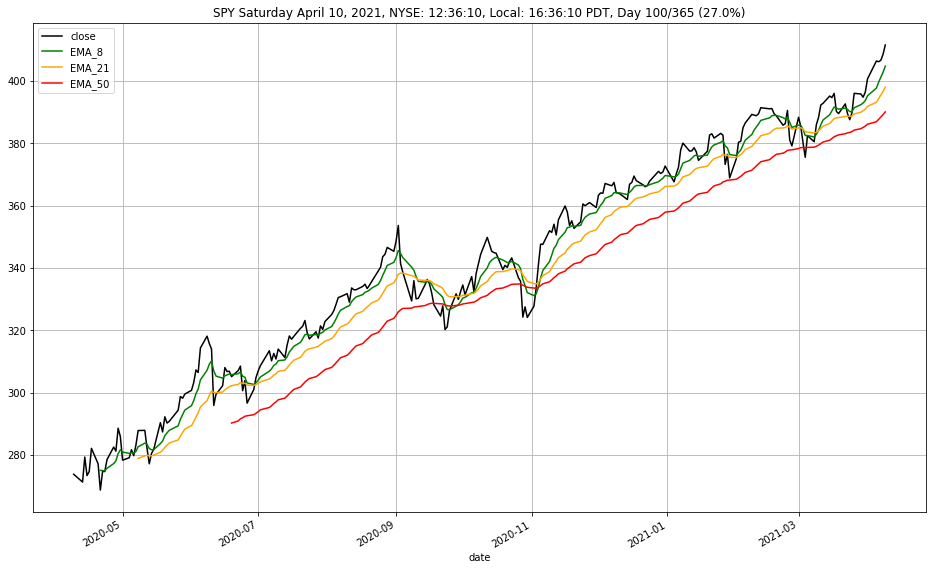

In [9]:
extime = ta.get_time(to_string=True)
chart_ = asset[["close", "EMA_8", "EMA_21", "EMA_50"]]
chart_.plot(figsize=(16, 10), color=colors("BkGrOrRd"), title=f"{ticker} {extime}", grid=True)

## Entries & Exits

In [10]:
entries = trendy.TR_Entries.astype(int) * asset.close
entries = entries[~np.isclose(entries, 0)]
entries.name = "Entry"

exits = trendy.TR_Exits.astype(int) * asset.close
exits = exits[~np.isclose(exits, 0)]
exits.name = "Exit"

total_trades = trendy.TR_Trades.abs().sum()
rt_trades = int(trendy.TR_Trades.abs().sum() // 2)
print(f"Total Trades: {total_trades}\t\tRT Trades: {rt_trades}")

all_trades = trendy.TR_Trades.copy().fillna(0)
all_trades = all_trades[all_trades != 0]

trades = pd.DataFrame({
    "Signal": all_trades,
    entries.name: entries.dropna(),
    exits.name: exits.dropna()
})
trades

Total Trades: 7		RT Trades: 3


,Signal,Entry,Exit
date,,,
2020-05-07,1,283.139404,NaN
2020-09-10,-1,NaN,330.066162
2020-10-02,1,331.337799,NaN
2020-10-27,-1,NaN,335.684937
2020-11-04,1,340.965088,NaN
2021-03-02,-1,NaN,385.278137
2021-03-09,1,385.906067,NaN


## Chart Display Strings

In [11]:
first_date, last_date = asset.index[0], asset.index[-1]
f_date = f"{first_date.day_name()} {first_date.month}-{first_date.day}-{first_date.year}"
l_date = f"{last_date.day_name()} {last_date.month}-{last_date.day}-{last_date.year}"
last_ohlcv = f"Last OHLCV: ({asset.iloc[-1].open:.4f}, {asset.iloc[-1].high:.4f}, {asset.iloc[-1].low:.4f}, {asset.iloc[-1].close:.4f}, {int(asset.iloc[-1].volume)})"
ptitle = f"\n{ticker} [{tf} for {duration}({recent} bars)] from {f_date} to {l_date}\n{last_ohlcv}\n{extime}"

## Trade Chart

<AxesSubplot:title={'center':'\nSPY [D for 1y(252 bars)] from Thursday 4-9-2020 to Friday 4-9-2021\nLast OHLCV: (408.3900, 411.6700, 408.2600, 411.4900, 61060100)\nSaturday April 10, 2021, NYSE: 12:36:10, Local: 16:36:10 PDT, Day 100/365 (27.0%)'}, xlabel='date'>

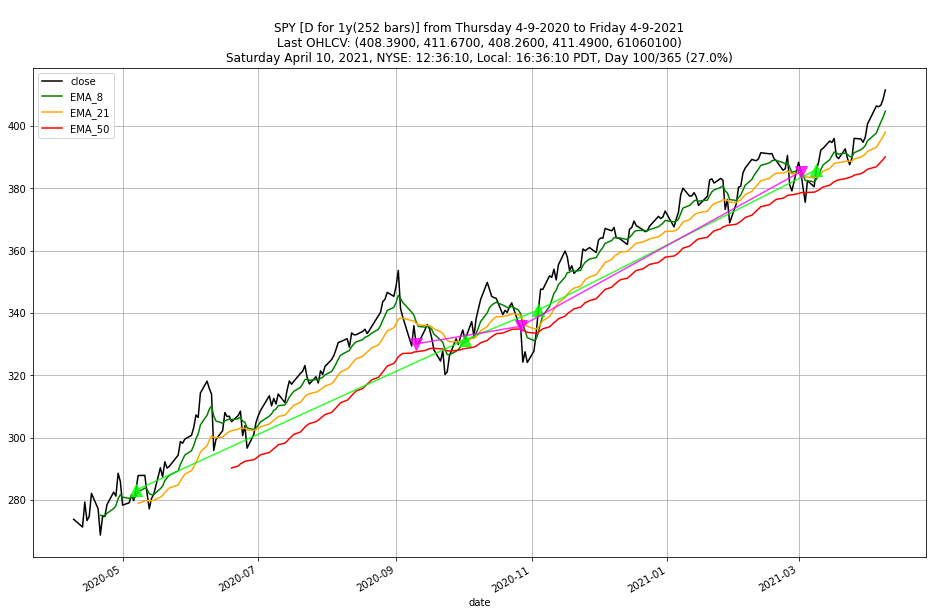

In [12]:
# chart = asset["close"] #asset[["close", "SMA_10", "SMA_20", "SMA_50", "SMA_200"]]
# chart = asset[["close", "SMA_10", "SMA_20"]]
chart = asset[["close", "EMA_8", "EMA_21", "EMA_50"]]
chart.plot(figsize=(16, 10), color=colors("BkGrOrRd"), title=ptitle, grid=True)
entries.plot(figsize=(16, 10), color=colors("FcLi")[1], marker="^", markersize=12, alpha=0.8)
exits.plot(figsize=(16, 10), color=colors("FcLi")[0], marker="v", markersize=12, alpha=0.8, grid=True)

## Active Returns and Cumulative Active Returns

<AxesSubplot:xlabel='date'>

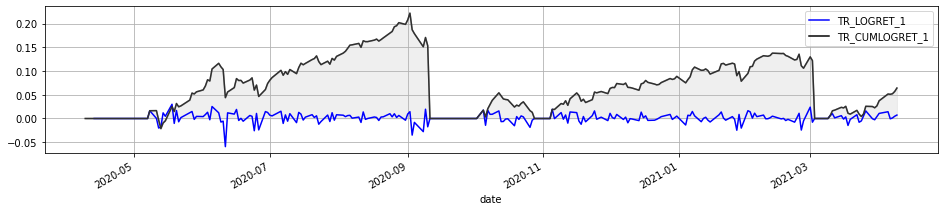

In [13]:
trendy.iloc[:,:2].plot(figsize=(16, 3), color=colors("BkBl")[::-1])
trendy.TR_CUMLOGRET_1.plot(figsize=(16, 3), kind="area", stacked=False, color=colors("SvGy")[0], alpha=0.25, grid=True)

# Total Return

<AxesSubplot:xlabel='date'>

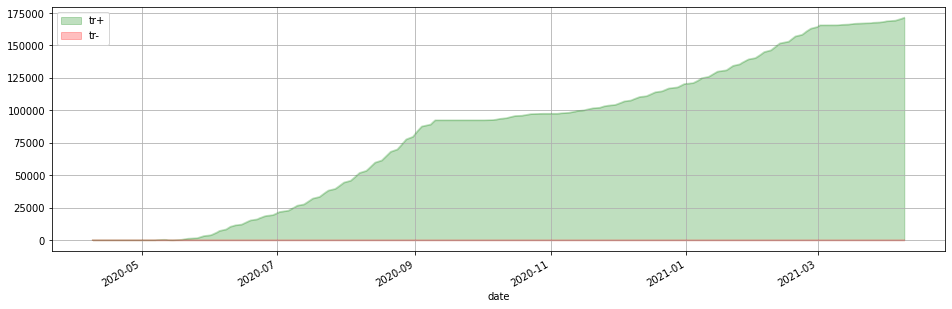

In [14]:
capital = 10000

total_return = trendy.TR_CUMLOGRET_1.cumsum() * capital
positive_return = total_return[total_return > 0]
negative_return = total_return[total_return <= 0]
trdf = pd.DataFrame({"tr+": positive_return, "tr-": negative_return})
trdf.plot(figsize=(16, 5), color=colors(), kind="area", stacked=False, alpha=0.25, grid=True)

## Long and Short Trends

<AxesSubplot:xlabel='date'>

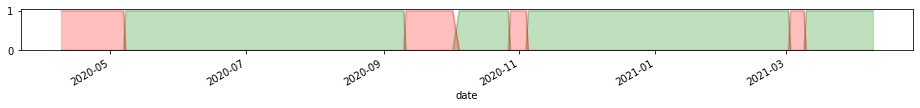

In [15]:
long_trend = (trendy.iloc[:,2] > 0).astype(int)
short_trend = (1 - long_trend).astype(int)

long_trend.plot(figsize=(16, 0.85), kind="area", stacked=True, color=colors()[0], alpha=0.25)
short_trend.plot(figsize=(16, 0.85), kind="area", stacked=True, color=colors()[1], alpha=0.25)

# AI Analysis

# Disclaimer
* All investments involve risk, and the past performance of a security, industry, sector, market, financial product, trading strategy, or individual’s trading does not guarantee future results or returns. Investors are fully responsible for any investment decisions they make. Such decisions should be based solely on an evaluation of their financial circumstances, investment objectives, risk tolerance, and liquidity needs.

* Any opinions, news, research, analyses, prices, or other information offered is provided as general market commentary, and does not constitute investment advice. I will not accept liability for any loss or damage, including without limitation any loss of profit, which may arise directly or indirectly from use of or reliance on such information.